In [4]:
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tensor
spikes_tensor = torch.load("tensors/spike_data_tensor.pt" ,map_location=device)
labels_tensor = torch.load("tensors/labels_tensor.pt", map_location=device)

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

spikes_tensor = spikes_tensor.to(device)
labels_tensor = labels_tensor.to(device)

Original Labels distribution: tensor([1294,   95, 1046,   53,   40], device='cuda:0')


In [7]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        # Random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Move tensors to the specified device
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

### Dataset and DataLoader Configuration

In [8]:
dataset = CCMKDataset(spikes_tensor, labels_tensor, nchannels=list(range(16)), seed=42)

# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Filtered Labels distribution after processing: tensor([1046, 1046])


In [12]:
# Adapted from Esther's snn.ipynb notebook

# Check the length of the dataset
print(f"Dataset length: {len(dataset)}")

# Get and print the shape of the first sample in the dataset
first_spikes, first_label = dataset[0]
print(f"Shape of the first spikes tensor: {first_spikes.shape}")
print(f"Label of the first sample: {first_label}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Get the distribution of labels
labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Dataset length: 2092
Shape of the first spikes tensor: torch.Size([16, 101])
Label of the first sample: 0
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([836, 836], device='cuda:0')


In [13]:
# Check the shape of tensors in a DataLoader
def check_dataloader_shapes(dataloader, loader_name=""):
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Loader: {loader_name}, Batch {batch_idx + 1}:")
        print(f" - Inputs shape: {inputs.shape}")  
        print(f" - Labels shape: {labels.shape}")  
        break 

check_dataloader_shapes(train_loader, "Train Loader")
check_dataloader_shapes(val_loader, "Validation Loader")
check_dataloader_shapes(test_loader, "Test Loader")


Loader: Train Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Validation Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Test Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])


### Network Initialization

In [42]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  # Number of input channels
n_classes = 1    # Number of output classes (assuming a binary classification task)
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

net = SynNet(
    #p_dropout = 0.1,
    n_channels=n_channels,                        
    n_classes=n_classes,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8]
)

print(net)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


### Train & Validation

  2%|▏         | 1/50 [00:34<28:31, 34.92s/it]

Epoch 1/50, Training Loss: 72.39917452830188, Validation Loss: 48.223214285714285


  4%|▍         | 2/50 [01:09<27:44, 34.67s/it]

Epoch 2/50, Training Loss: 54.45518867924528, Validation Loss: 58.924107142857146


  6%|▌         | 3/50 [01:44<27:17, 34.85s/it]

Epoch 3/50, Training Loss: 50.962853773584904, Validation Loss: 45.46875


  8%|▊         | 4/50 [02:19<26:42, 34.83s/it]

Epoch 4/50, Training Loss: 45.48466981132076, Validation Loss: 41.64732142857143


 10%|█         | 5/50 [02:53<25:55, 34.56s/it]

Epoch 5/50, Training Loss: 41.79658018867924, Validation Loss: 35.80357142857143


 12%|█▏        | 6/50 [03:27<25:12, 34.37s/it]

Epoch 6/50, Training Loss: 39.0872641509434, Validation Loss: 34.21875


 14%|█▍        | 7/50 [04:01<24:30, 34.21s/it]

Epoch 7/50, Training Loss: 37.425707547169814, Validation Loss: 41.11607142857143


 16%|█▌        | 8/50 [04:35<23:55, 34.17s/it]

Epoch 8/50, Training Loss: 34.768278301886795, Validation Loss: 32.857142857142854


 18%|█▊        | 9/50 [05:09<23:18, 34.11s/it]

Epoch 9/50, Training Loss: 33.1686320754717, Validation Loss: 30.647321428571427


 20%|██        | 10/50 [05:43<22:46, 34.16s/it]

Epoch 10/50, Training Loss: 31.276533018867923, Validation Loss: 27.089285714285715


 22%|██▏       | 11/50 [06:17<22:12, 34.17s/it]

Epoch 11/50, Training Loss: 29.284787735849058, Validation Loss: 28.772321428571427


 24%|██▍       | 12/50 [06:52<21:39, 34.20s/it]

Epoch 12/50, Training Loss: 27.87382075471698, Validation Loss: 28.116071428571427


 26%|██▌       | 13/50 [07:25<20:58, 34.02s/it]

Epoch 13/50, Training Loss: 27.73879716981132, Validation Loss: 23.669642857142858


 28%|██▊       | 14/50 [07:58<20:14, 33.74s/it]

Epoch 14/50, Training Loss: 29.08549528301887, Validation Loss: 24.446428571428573


 30%|███       | 15/50 [08:32<19:39, 33.71s/it]

Epoch 15/50, Training Loss: 27.14622641509434, Validation Loss: 22.950892857142858


 32%|███▏      | 16/50 [09:05<19:00, 33.55s/it]

Epoch 16/50, Training Loss: 23.359669811320753, Validation Loss: 25.209821428571427


 34%|███▍      | 17/50 [09:38<18:24, 33.46s/it]

Epoch 17/50, Training Loss: 23.495872641509433, Validation Loss: 20.883928571428573


 36%|███▌      | 18/50 [10:12<17:51, 33.47s/it]

Epoch 18/50, Training Loss: 22.058962264150942, Validation Loss: 28.660714285714285


 38%|███▊      | 19/50 [10:45<17:16, 33.45s/it]

Epoch 19/50, Training Loss: 23.1686320754717, Validation Loss: 20.25


 40%|████      | 20/50 [11:18<16:39, 33.32s/it]

Epoch 20/50, Training Loss: 21.015919811320753, Validation Loss: 21.660714285714285


 42%|████▏     | 21/50 [11:52<16:05, 33.31s/it]

Epoch 21/50, Training Loss: 22.04304245283019, Validation Loss: 23.6875


 44%|████▍     | 22/50 [12:25<15:30, 33.23s/it]

Epoch 22/50, Training Loss: 20.76002358490566, Validation Loss: 24.428571428571427


 46%|████▌     | 23/50 [12:58<14:58, 33.27s/it]

Epoch 23/50, Training Loss: 21.86497641509434, Validation Loss: 28.651785714285715


 48%|████▊     | 24/50 [13:31<14:26, 33.33s/it]

Epoch 24/50, Training Loss: 22.14622641509434, Validation Loss: 40.03125


 50%|█████     | 25/50 [14:05<13:54, 33.38s/it]

Epoch 25/50, Training Loss: 23.93514150943396, Validation Loss: 16.665178571428573


 52%|█████▏    | 26/50 [14:38<13:21, 33.38s/it]

Epoch 26/50, Training Loss: 22.044811320754718, Validation Loss: 20.334821428571427


 54%|█████▍    | 27/50 [15:12<12:47, 33.39s/it]

Epoch 27/50, Training Loss: 26.42629716981132, Validation Loss: 30.169642857142858


 56%|█████▌    | 28/50 [15:45<12:13, 33.33s/it]

Epoch 28/50, Training Loss: 20.711674528301888, Validation Loss: 17.236607142857142


 58%|█████▊    | 29/50 [16:18<11:40, 33.35s/it]

Epoch 29/50, Training Loss: 19.610849056603772, Validation Loss: 20.21875


 60%|██████    | 30/50 [16:52<11:07, 33.37s/it]

Epoch 30/50, Training Loss: 18.86615566037736, Validation Loss: 17.392857142857142


 62%|██████▏   | 31/50 [17:25<10:34, 33.38s/it]

Epoch 31/50, Training Loss: 18.659198113207548, Validation Loss: 17.169642857142858


 64%|██████▍   | 32/50 [17:58<09:59, 33.28s/it]

Epoch 32/50, Training Loss: 21.32311320754717, Validation Loss: 18.941964285714285


 66%|██████▌   | 33/50 [18:31<09:24, 33.20s/it]

Epoch 33/50, Training Loss: 18.515919811320753, Validation Loss: 23.866071428571427


 68%|██████▊   | 34/50 [19:05<08:55, 33.45s/it]

Epoch 34/50, Training Loss: 18.51120283018868, Validation Loss: 25.107142857142858


 70%|███████   | 35/50 [19:39<08:23, 33.54s/it]

Epoch 35/50, Training Loss: 21.701650943396228, Validation Loss: 17.888392857142858


 72%|███████▏  | 36/50 [20:13<07:50, 33.63s/it]

Epoch 36/50, Training Loss: 19.72641509433962, Validation Loss: 17.513392857142858


 74%|███████▍  | 37/50 [20:47<07:18, 33.71s/it]

Epoch 37/50, Training Loss: 18.93632075471698, Validation Loss: 17.691964285714285


 76%|███████▌  | 38/50 [21:21<06:48, 34.04s/it]

Epoch 38/50, Training Loss: 19.17452830188679, Validation Loss: 22.254464285714285


 78%|███████▊  | 39/50 [21:58<06:22, 34.73s/it]

Epoch 39/50, Training Loss: 18.76120283018868, Validation Loss: 17.977678571428573


 80%|████████  | 40/50 [22:33<05:48, 34.86s/it]

Epoch 40/50, Training Loss: 17.77004716981132, Validation Loss: 24.316964285714285


 82%|████████▏ | 41/50 [23:08<05:14, 34.89s/it]

Epoch 41/50, Training Loss: 17.327240566037737, Validation Loss: 27.879464285714285


 84%|████████▍ | 42/50 [23:44<04:42, 35.27s/it]

Epoch 42/50, Training Loss: 20.0813679245283, Validation Loss: 21.946428571428573


 86%|████████▌ | 43/50 [24:19<04:05, 35.07s/it]

Epoch 43/50, Training Loss: 18.43573113207547, Validation Loss: 17.450892857142858


 88%|████████▊ | 44/50 [24:53<03:29, 34.91s/it]

Epoch 44/50, Training Loss: 17.50825471698113, Validation Loss: 22.0625


 90%|█████████ | 45/50 [25:28<02:54, 34.93s/it]

Epoch 45/50, Training Loss: 23.03242924528302, Validation Loss: 19.455357142857142


 92%|█████████▏| 46/50 [26:03<02:19, 34.76s/it]

Epoch 46/50, Training Loss: 22.442806603773583, Validation Loss: 18.977678571428573


 94%|█████████▍| 47/50 [26:41<01:47, 35.72s/it]

Epoch 47/50, Training Loss: 21.3125, Validation Loss: 22.727678571428573


 96%|█████████▌| 48/50 [27:16<01:11, 35.71s/it]

Epoch 48/50, Training Loss: 17.067216981132077, Validation Loss: 18.34375


 98%|█████████▊| 49/50 [27:52<00:35, 35.83s/it]

Epoch 49/50, Training Loss: 17.42570754716981, Validation Loss: 18.986607142857142


100%|██████████| 50/50 [28:28<00:00, 34.16s/it]

Epoch 50/50, Training Loss: 16.35200471698113, Validation Loss: 17.008928571428573


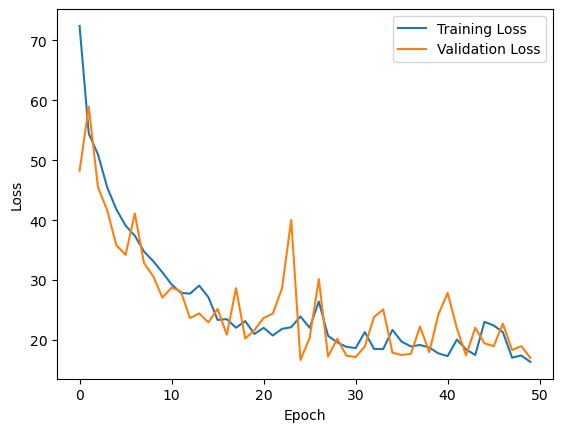

In [43]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3
target_firing_rate_value = 10  

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs_sum = outputs.sum(dim=1)  # Sum over the time dimension

        # target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(device)
        target_firing_rate[labels == 1] = target_firing_rate_value
        target_firing_rate[labels == 0] = 0

        loss = loss_fun(outputs_sum, target_firing_rate)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

    
    # Validation phase
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1)
            outputs, _, _ = net(inputs)
            outputs_sum = outputs.sum(dim=1)
            target_firing_rate = torch.zeros_like(outputs_sum).to(device)
            target_firing_rate[labels == 1] = target_firing_rate_value
            target_firing_rate[labels == 0] = 0
            loss = loss_fun(outputs_sum, target_firing_rate)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))  

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [17]:
# Hyperparameters
n_epochs = 50
learning_rate = 1e-3

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = CrossEntropyLoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :]
        loss = loss_fun(outputs, labels.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

# Track all predictions and true labels
all_outputs = []
all_labels = []

# Validation phase
net.eval()
val_loss = 0
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :]
        loss = loss_fun(outputs, labels.long())
        val_loss += loss.item()

        # Collect predictions and true labels
        all_outputs.append(outputs)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_outputs = torch.cat(all_outputs).cpu()
all_labels = torch.cat(all_labels).cpu()

# Convert to numpy for metric calculations
y_pred_proba = all_outputs.numpy()
y_true = all_labels.numpy()

val_losses.append(val_loss / len(val_loader))

print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


100%|██████████| 50/50 [10:35<00:00, 12.72s/it]


Epoch 50/50, Training Loss: 0.42144895836992086, Validation Loss: 0.43861060057367596


Validation Accuracy: 0.89
ROC-AUC Score: 0.86


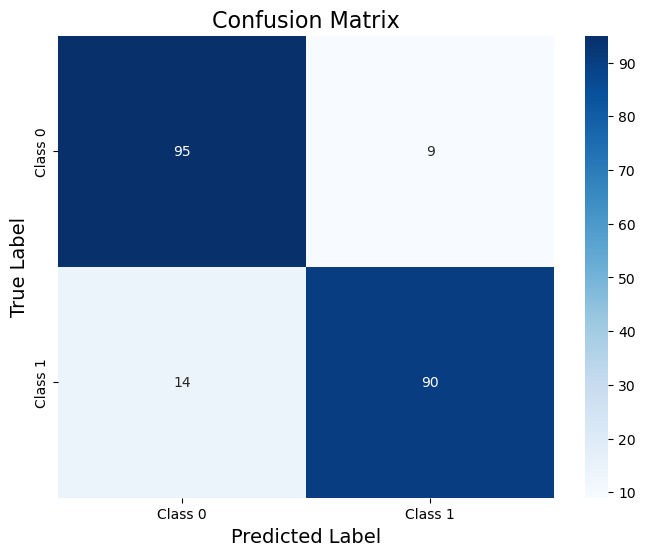

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


# Get the predicted class by taking the argmax (highest probability)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])  # Use probabilities for the positive class
print(f"ROC-AUC Score: {roc_auc:.2f}")

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],  # Adjust labels according to your classes
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()



In [28]:
#generate classification report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.87      0.91      0.89       104
     Class 1       0.91      0.87      0.89       104

    accuracy                           0.89       208
   macro avg       0.89      0.89      0.89       208
weighted avg       0.89      0.89      0.89       208

